In [1]:
import czifile
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import napari
from glob import glob
from os import path
import scipy
import pandas as pd
from skimage.filters import threshold_otsu, threshold_multiotsu
from scipy import ndimage

In [2]:
#function for reading czi files
def read_czi(file_path):
    img = czifile.imread(file_path)
    img = img[0,0,:,0,0,:,:,0] # remove extra dimensions
    return (img)

In [4]:
img_files = sorted(glob("../data/*.czi"))
file_names = [path.basename(a) for a in img_files]

print(file_names)

['IWR1 10uM_n=1_10X 1.0zoom 2x2tile.czi', 'IWR1 10uM_n=2_10X 1.0zoom 2x2tile.czi', 'IWR1 10uM_n=3_10X 1.0zoom 2x2tile.czi', 'PBS control_n=1_10X 1.0zoom 2x2tile.czi', 'PBS control_n=2_10X 1.0zoom 2x2tile.czi', 'PBS control_n=3_10X 1.0zoom 2x2tile.czi']


In [4]:
#generate sample matrix to check that conditions correctly match

condition = ["IWR", "IWR", "IWR", "PBS", "PBS", "PBS"]
sample_matrix = pd.DataFrame({'file':file_names, 'condition': condition})
sample_matrix

,file,condition
0,IWR1 10uM_n=1_10X 1.0zoom 2x2tile.czi,IWR
1,IWR1 10uM_n=2_10X 1.0zoom 2x2tile.czi,IWR
2,IWR1 10uM_n=3_10X 1.0zoom 2x2tile.czi,IWR
3,PBS control_n=1_10X 1.0zoom 2x2tile.czi,PBS
4,PBS control_n=2_10X 1.0zoom 2x2tile.czi,PBS
5,PBS control_n=3_10X 1.0zoom 2x2tile.czi,PBS


In [5]:
#load all image files and annotation files and check that dimensions and indicies are correct

img_list = []
labels_list = []

for file_idx, name in enumerate(img_files):
    print(file_idx)
    
    labels_file = 'labels_' + str(file_idx) + ".tif"
    print(labels_file)
    labels = io.imread(labels_file)
    print(labels.shape)
    labels_list.append(labels)
    
    print(name)
    print(path.exists(name))
    img = read_czi(name)
    print(img.shape)
    img_list.append(img)
    

0
labels_0.tif
(1944, 1944)
../10x curated\IWR1 10uM_n=1_10X 1.0zoom 2x2tile.czi
True
(4, 1944, 1944)
1
labels_1.tif
(1944, 1944)
../10x curated\IWR1 10uM_n=2_10X 1.0zoom 2x2tile.czi
True
(4, 1944, 1944)
2
labels_2.tif
(1944, 1944)
../10x curated\IWR1 10uM_n=3_10X 1.0zoom 2x2tile.czi
True
(4, 1944, 1944)
3
labels_3.tif
(1944, 1944)
../10x curated\PBS control_n=1_10X 1.0zoom 2x2tile.czi
True
(4, 1944, 1944)
4
labels_4.tif
(1944, 1944)
../10x curated\PBS control_n=2_10X 1.0zoom 2x2tile.czi
True
(4, 1944, 1944)
5
labels_5.tif
(1944, 1944)
../10x curated\PBS control_n=3_10X 1.0zoom 2x2tile.czi
True
(4, 1944, 1944)


In [6]:
#function for thresholding using standard otsu method afer gaussian filter.
def gauss_and_thresh(image, sigma = 5):
    image = ndimage.gaussian_filter(image, sigma)
    thresh = threshold_otsu(image)
    print(thresh)
    return (image > thresh)

#function for thresholding using multi-otsu after gaussian filter.
def gauss_and_multithresh(image, sigma = 5):
    image = ndimage.gaussian_filter(image, sigma)
    thresh = threshold_multiotsu(image)
    print(thresh)
    return (image > thresh[1])

#define variables to store output
beads_dist_map = []
epcam_segs = []
ltl_segs = []
glom_segs = []
prox_segs = []
dist_segs = []
beads_lines = []

#metrics for plotting
rad = [] #beads radius
gir = [] #gloms in radius
lir = [] #ltl in radius
eir = [] #epcam in radius
prir = [] #prox in radius
dtir = [] #distal in radius
glepir = [] #glom + epcam in radius

for labels, img in zip(labels_list, img_list):
    
    #define distance from beads using distance transform
    
    binary_beads = labels > 0
    binary_beads = 1 - binary_beads.astype('int')
    beads_dist = scipy.ndimage.morphology.distance_transform_edt(binary_beads)
    beads_dist_map.append(beads_dist)
    
    #segmentation
    
    glom = gauss_and_thresh(img[0,:,:], sigma = 5)
    glom_segs.append(glom)
    
    ltl = gauss_and_multithresh(img[2,:,:], sigma = 5)
    ltl_segs.append(ltl)
    
    epcam = gauss_and_multithresh(img[3,:,:], sigma = 5)
    epcam_segs.append(epcam)
    
    #define radius
    beads_radius = beads_dist < 200
    rad.append(np.sum(beads_radius))
    
    #define line used for generating visualisation
    beads_line = (beads_dist > 195) & (beads_dist < 205)
    beads_lines.append(beads_line)
    
    #find segmented pixels in radius
    glom_in_radius = glom & beads_radius
    gir.append(np.sum(glom_in_radius))
    
    ltl_in_radius = ltl & beads_radius
    lir.append(np.sum(ltl_in_radius))
    
    epcam_in_radius = epcam & beads_radius
    eir.append(np.sum(epcam_in_radius))
    
    glom_plus_epcam = epcam_in_radius + glom_in_radius
    glepir.append(np.sum(glom_plus_epcam))
    
    proximal = ltl & epcam
    prox_segs.append(proximal)
    prox_in_radius = proximal & beads_radius
    prir.append(np.sum(prox_in_radius))
    
    distal = np.invert(ltl) & epcam
    dist_segs.append(distal)
    dist_in_radius = distal & beads_radius
    dtir.append(np.sum(dist_in_radius))
    
    print("total pixels in radius: {}".format(np.sum(beads_radius)))
    
    print("gloms in radius: {}".format(np.sum(glom_in_radius)))
    print("glom %: {}".format(np.sum(glom_in_radius) / np.sum(beads_radius)))
    
    print("ltl in radius: {}".format(np.sum(ltl_in_radius)))
    print("ltl %: {}".format(np.sum(ltl_in_radius) / np.sum(beads_radius)))
    
    print("epcam in radius: {}".format(np.sum(epcam_in_radius)))
    print("epcam %: {}".format(np.sum(epcam_in_radius) / np.sum(beads_radius)))
    
    print("total proximal pixels in radius: {}".format(np.sum(prox_in_radius)))
    print("proximal %: {}".format(np.sum(prox_in_radius) / np.sum(beads_radius)))
    
    print("total distal pixels in radius: {}".format(np.sum(dist_in_radius)))
    print("distal %: {}".format(np.sum(dist_in_radius) / np.sum(beads_radius)))
    
    


4775
[ 4804 13459]
[1622 4373]
total pixels in radius: 1905017
gloms in radius: 495180
glom %: 0.25993468824687654
ltl in radius: 41898
ltl %: 0.02199350451990717
epcam in radius: 92217
epcam %: 0.048407442033325684
total proximal pixels in radius: 41623
proximal %: 0.0218491488527399
total distal pixels in radius: 50594
distal %: 0.02655829318058579
10072
[ 4112 11478]
[3582 7614]
total pixels in radius: 1436790
gloms in radius: 592680
glom %: 0.41250287098323346
ltl in radius: 27171
ltl %: 0.01891090556031153
epcam in radius: 69770
epcam %: 0.04855963641172335
total proximal pixels in radius: 24449
proximal %: 0.017016404624196995
total distal pixels in radius: 45321
distal %: 0.03154323178752636
6044
[ 6125 13300]
[3522 7045]
total pixels in radius: 1732366
gloms in radius: 746348
glom %: 0.4308258185625901
ltl in radius: 40231
ltl %: 0.023223152613246853
epcam in radius: 99303
epcam %: 0.05732218249492313
total proximal pixels in radius: 37329
proximal %: 0.02154798697272978
total 

In [7]:
all_data = pd.concat([sample_matrix, 
           pd.Series(data = rad, name = "bead_radius"),
           pd.Series(data = gir, name = "gloms_in_radius"),
           pd.Series(data = lir, name = "ltl_in_radius"),
           pd.Series(data = eir, name = "epcam_in_radius"),
           pd.Series(data = prir, name = "proximal_in_radius"),
           pd.Series(data = dtir, name = "distal_in_radius"), 
            pd.Series(data = glepir, name = "tissue_in_radius")], axis = 1)

all_data

,file,condition,bead_radius,gloms_in_radius,ltl_in_radius,epcam_in_radius,proximal_in_radius,distal_in_radius,tissue_in_radius
0,IWR1 10uM_n=1_10X 1.0zoom 2x2tile.czi,IWR,1905017,495180,41898,92217,41623,50594,577495
1,IWR1 10uM_n=2_10X 1.0zoom 2x2tile.czi,IWR,1436790,592680,27171,69770,24449,45321,621571
2,IWR1 10uM_n=3_10X 1.0zoom 2x2tile.czi,IWR,1732366,746348,40231,99303,37329,61974,838595
3,PBS control_n=1_10X 1.0zoom 2x2tile.czi,PBS,1995803,722679,115372,241557,100044,141513,946907
4,PBS control_n=2_10X 1.0zoom 2x2tile.czi,PBS,1404122,651280,78934,203536,70993,132543,825990
5,PBS control_n=3_10X 1.0zoom 2x2tile.czi,PBS,1877655,734616,72331,204901,70496,134405,916286


In [8]:
#save all output to csv file

all_data.to_csv("all_data_output.csv")

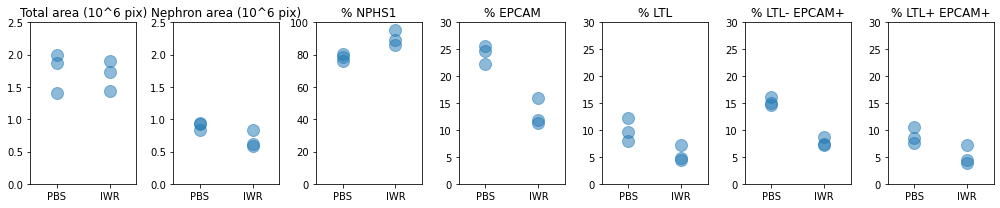

In [8]:
#code for generating plots

fig, axs = plt.subplots(1, 7, figsize=(14, 3))

cond = all_data['condition']
total_bead_area = all_data["bead_radius"] / 1000000
total_tissue = all_data["tissue_in_radius"] / 1000000
dist = all_data["distal_in_radius"] / all_data["tissue_in_radius"] * 100
prox = all_data["proximal_in_radius"] / all_data["tissue_in_radius"] * 100
glom = all_data["gloms_in_radius"] / all_data["tissue_in_radius"] * 100
ltl = all_data["ltl_in_radius"] / all_data["tissue_in_radius"] * 100
epcam = all_data["epcam_in_radius"] / all_data["tissue_in_radius"] * 100

axs[0].plot(cond, total_bead_area, marker='o', linestyle='', ms=12, alpha = 0.5)
axs[0].margins(0.5,0.2)
axs[0].set_ylim([0,2.5])
axs[0].invert_xaxis()
axs[0].set_title("Total area (10^6 pix)")

axs[1].plot(cond, total_tissue, marker='o', linestyle='', ms=12, alpha = 0.5)
axs[1].margins(0.5,0.2)
axs[1].set_ylim([0,2.5])
axs[1].invert_xaxis()
axs[1].set_title("Nephron area (10^6 pix)")

axs[2].plot(cond, glom, marker='o', linestyle='', ms=12, alpha=0.5)
axs[2].margins(0.5,0.2)
axs[2].set_ylim([0,100])
axs[2].invert_xaxis()
axs[2].set_title("% NPHS1")

axs[3].plot(cond, epcam, marker='o', linestyle='', ms=12, alpha=0.5)
axs[3].margins(0.5,0.2)
axs[3].set_ylim([0,30])
axs[3].invert_xaxis()
axs[3].set_title("% EPCAM")

axs[4].plot(cond, ltl, marker='o', linestyle='', ms=12, alpha=0.5)
axs[4].margins(0.5,0.2)
axs[4].set_ylim([0,30])
axs[4].invert_xaxis()
axs[4].set_title("% LTL")

axs[5].plot(cond, dist, marker='o', linestyle='', ms=12, alpha=0.5)
axs[5].margins(0.5,0.2)
axs[5].set_ylim([0,30])
axs[5].invert_xaxis()
axs[5].set_title("% LTL- EPCAM+")

axs[6].plot(cond, prox, marker='o', linestyle='', ms=12, alpha = 0.5)
axs[6].margins(0.5,0.2)
axs[6].set_ylim([0,30])
axs[6].invert_xaxis()
axs[6].set_title("% LTL+ EPCAM+")


fig.tight_layout()
plt.show()
fig.savefig("finalplots.tif", dpi=300)

In [9]:
#code for loading all segmented images into napari for visualisation.

viewer = napari.view_image(np.array(img_list), channel_axis=1, colormap=["gray","yellow","green","blue"])
labels_layer = viewer.add_labels(np.array(labels_list), name="segmentation")
dist_map = viewer.add_image(np.array(beads_dist_map), name="dist", colormap="viridis", blending = 'additive')
glom_layer = viewer.add_image(np.array(glom_segs), name="glom", colormap="red", blending = 'additive')
epcam_layer = viewer.add_image(np.array(epcam_segs), name="epcam", colormap="red", blending = 'additive')
prox_layer = viewer.add_image(np.array(ltl_segs), name="ltl", colormap="green", blending = 'additive')
#dist_layer = viewer.add_image(np.array(dist_segs), name="dist", blending = 'additive')
radius_layer = viewer.add_image(np.array(beads_lines), name="radius", blending = "additive")
napari.run()

In [63]:
#code for calculating mean values

norm_values = all_data["tissue_in_radius"]
df = all_data[["gloms_in_radius","ltl_in_radius","epcam_in_radius","proximal_in_radius","distal_in_radius"]] 
df_norm = df.div(norm_values, axis=0) * 100
df_norm = pd.concat([all_data["condition"], df_norm], axis=1)

print(df_norm)
df_norm.groupby("condition").mean()

  condition  gloms_in_radius  ltl_in_radius  epcam_in_radius  \
0       IWR        85.779097       7.246745        15.956400   
1       IWR        95.351939       4.371343        11.224784   
2       IWR        89.015100       4.798253        11.808561   
3       PBS        76.319955      12.184090        25.510108   
4       PBS        78.848412       9.556290        24.641461   
5       PBS        80.209251       7.860895        22.363952   

   proximal_in_radius  distal_in_radius  
0            7.203678          8.752722  
1            3.933420          7.291363  
2            4.460726          7.347835  
3           10.565346         14.944762  
4            8.594898         16.046562  
5            7.650491         14.713461  


,gloms_in_radius,ltl_in_radius,epcam_in_radius,proximal_in_radius,distal_in_radius
condition,,,,,
IWR,90.048712,5.472114,12.996582,5.199275,7.797307
PBS,78.459206,9.867092,24.171840,8.936912,15.234929


In [55]:
#generate separate dataframe for each condition to allow t tests below.

pbs = df_norm[df_norm['condition'] == 'PBS']
iwr = df_norm[df_norm['condition'] == 'IWR']


3    76.319955
4    78.848412
5    80.209251
Name: gloms_in_radius, dtype: float64

In [64]:
#performing t-tests

print("% Nphs1: {}".format(scipy.stats.ttest_ind(pbs['gloms_in_radius'],iwr['gloms_in_radius'])))

print("% LTL: {}".format(scipy.stats.ttest_ind(pbs['ltl_in_radius'],iwr['ltl_in_radius'])))

print("% Epcam: {}".format(scipy.stats.ttest_ind(pbs['epcam_in_radius'],iwr['epcam_in_radius'])))

print("% LTL+ Epcam+: {}".format(scipy.stats.ttest_ind(pbs['proximal_in_radius'],iwr['proximal_in_radius'])))

print("% LTL- Epcam+: {}".format(scipy.stats.ttest_ind(pbs['distal_in_radius'],iwr['distal_in_radius'])))

% Nphs1: Ttest_indResult(statistic=-3.8205068990045494, pvalue=0.018770133532865836)
% LTL: Ttest_indResult(statistic=2.8463498199686357, pvalue=0.04656738625960502)
% Epcam: Ttest_indResult(statistic=6.348631465830753, pvalue=0.0031535935725756654)
% LTL+ Epcam+: Ttest_indResult(statistic=2.8134731060127587, pvalue=0.04814651215289006)
% LTL- Epcam+: Ttest_indResult(statistic=11.795115545920902, pvalue=0.00029567396175098087)


In [70]:
#t tests for raw values

print(all_data)

pbs_raw = all_data[all_data['condition'] == 'PBS']
iwr_raw = all_data[all_data['condition'] == 'IWR']

print("total bead area: {}".format(scipy.stats.ttest_ind(pbs_raw['bead_radius'],iwr_raw['bead_radius'])))
print("total tissue area: {}".format(scipy.stats.ttest_ind(pbs_raw['tissue_in_radius'],iwr_raw['tissue_in_radius'])))

                                      file condition  bead_radius  \
0    IWR1 10uM_n=1_10X 1.0zoom 2x2tile.czi       IWR      1905017   
1    IWR1 10uM_n=2_10X 1.0zoom 2x2tile.czi       IWR      1436790   
2    IWR1 10uM_n=3_10X 1.0zoom 2x2tile.czi       IWR      1732366   
3  PBS control_n=1_10X 1.0zoom 2x2tile.czi       PBS      1995803   
4  PBS control_n=2_10X 1.0zoom 2x2tile.czi       PBS      1404122   
5  PBS control_n=3_10X 1.0zoom 2x2tile.czi       PBS      1877655   

   gloms_in_radius  ltl_in_radius  epcam_in_radius  proximal_in_radius  \
0           495943          41898            92254               41649   
1           592680          27171            69770               24449   
2           746348          40231            99009               37401   
3           722679         115372           241557              100044   
4           651280          78934           203536               70993   
5           738035          72331           205779               70395  